 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [25]:
# !pip install torchvision

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import notebook

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Скачаем обучающую и контрольную выборки.

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = {
  0: "T-shirt/top",
  1: "Trouser",
  2: "Pullover",
  3: "Dress",
  4: "Coat", 
  5: "Sandal", 
  6: "Shirt",
  7: "Sneaker",
  8: "Bag",
  9: "Ankle boot"
}

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot|

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [3]:
print(f'train: {trainloader.dataset.data.shape[0]} \ntest: {testloader.dataset.data.shape[0]}')

train: 60000 
test: 10000


In [4]:
trainset.targets.unique(return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [5]:
testset.targets.unique(return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

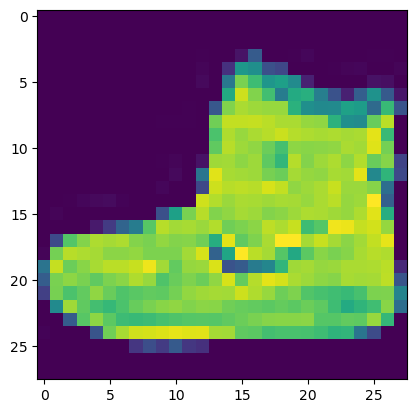

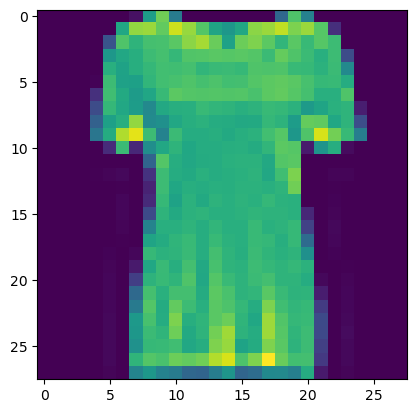

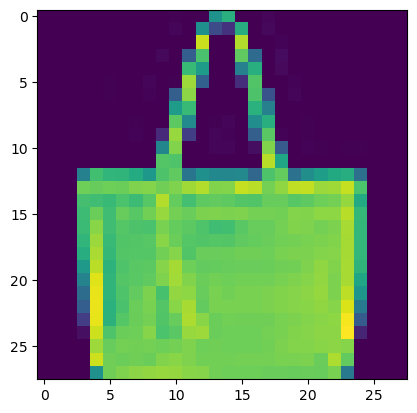

In [6]:
plt.imshow(trainloader.dataset.data[0])
plt.show()
plt.imshow(trainloader.dataset.data[10])
plt.show()
plt.imshow(testloader.dataset.data[900])
plt.show()

In [27]:
N, D_in, H, D_out = 4, 784, 200, 10

mlp = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
mlp.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
lr = 1e-4
optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)
losses = []

for epoch in notebook.tqdm(range(5)):
    running_loss = 0.0
    for i, batch in enumerate(notebook.tqdm(trainloader)):
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        y_pred = mlp(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            losses.append(running_loss / 1000)
            running_loss = 0.0

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

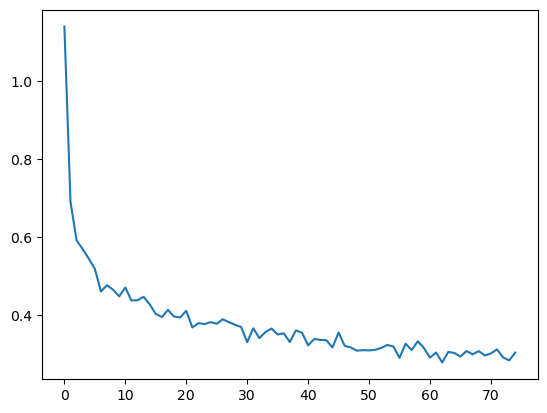

In [8]:
plt.plot(losses)

In [9]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        y_pred = mlp(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(N):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(D_out):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('\nTotal accuracy: ', (sum(class_correct) / sum(class_total)) * 100, '%')

Accuracy of T-shirt/top : 74 %
Accuracy of Trouser : 97 %
Accuracy of Pullover : 68 %
Accuracy of Dress : 85 %
Accuracy of  Coat : 87 %
Accuracy of Sandal : 93 %
Accuracy of Shirt : 75 %
Accuracy of Sneaker : 96 %
Accuracy of   Bag : 96 %
Accuracy of Ankle boot : 95 %

Total accuracy:  87.05000000000001 %


In [43]:
import torch.nn.functional as F

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.fc1 = nn.Linear(32 * 5 * 5, 300)
        self.fc2 = nn.Linear(300, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [44]:
cnn = CNN()
cnn.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)
losses = []

for epoch in notebook.tqdm(range(5)):
    running_loss = 0.0
    for i, batch in enumerate(notebook.tqdm(trainloader)):
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        y_pred = cnn(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            losses.append(running_loss / 1000)
            running_loss = 0.0

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

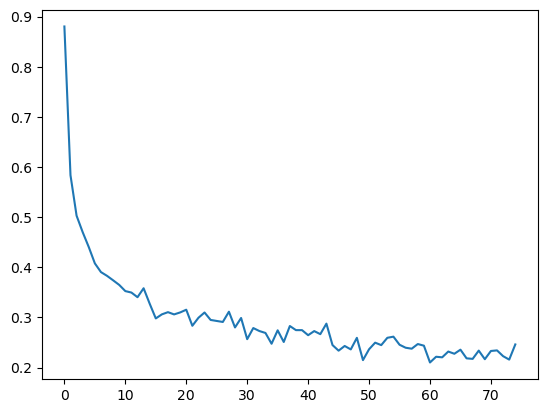

In [45]:
plt.plot(losses)

In [46]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        y_pred = cnn(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(N):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(D_out):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('\nTotal accuracy: ', (sum(class_correct) / sum(class_total)) * 100, '%')

Accuracy of T-shirt/top : 83 %
Accuracy of Trouser : 97 %
Accuracy of Pullover : 90 %
Accuracy of Dress : 92 %
Accuracy of  Coat : 72 %
Accuracy of Sandal : 97 %
Accuracy of Shirt : 72 %
Accuracy of Sneaker : 98 %
Accuracy of   Bag : 97 %
Accuracy of Ankle boot : 94 %

Total accuracy:  89.58 %
